# Lab2 - Maciej Złotrowicz
## Wstęp teoretyczny
Labolatorium 2 dotyczy regresji liniowej z użyciem biblioteki `sklearn` i podstawowuch narzędzi do manipulacji danych `pandas` i `numpy`

### Regresja liniowa

Regresja liniowa to jeden z naprostychzych modeli uczenia maszynowego. Polega ona na dopasowaniu funkcji liniowej do zbioru danych. 

Funkcja ta ma postać:
$$
y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_n x_n
$$
lub w postaci macierzowej
$$
y = \theta^T x
$$
Gdzie $y$ to predyktowana wartość, $x$ to wektor wartości niezależnych, a $\theta$ to wektor parametrów modelu. W przypadku regresji liniowej parametry $\theta$ są szukane tak, aby funkcja kosztu była **minimalna**. Najczęściej stosowaną funkcją kosztu jest funkcja `mean_squared_error`
$$
MSE = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
$$
Więc zadaniem algorytmu `LinearRegression` jest znalezienie takich parametrów $\theta$, aby funkcja kosztu `MSE` była minimalna dla podanych danych treningowych. Problem ten jest możliwy do rozwiązania przy użyciu algorytmu `Normal Equation` albo `Gradient Decent` 

`Gradient Decent` jest bardziej praktyczny przy obliczeniach numerycznych więc w tym laboratorium będziemy go używać.

### Spadek po gradniencie

Spadek po gradiencie to prosty algorytm który iteracyjnie poprawia swoje rozwiązanie ($\theta$) modyfikując jego wartości o pewny gradient obliczany na podstawie danych treningowych.

Po zróżniczkowaniu funkcji kosztu `MSE` otrzymujemy:
$$
\frac{\partial MSE}{\partial \theta_i} = \frac{1}{n} \sum_{i=1}^n (h_\theta(x^{(i)}) - y^{(i)}) x^{(i)}
$$
Gdzie $\frac{2}{n}$ jest stałą i można ją pominąć a $h_\theta(x)$ to predykcja modelu dla danych czyli $\theta^T x^{(i)}$

Cały algorytm iteracyjnie updatuje $\vartheta$

$$
\begin{align*} 
\vartheta & := \vartheta - \eta \sum_{i=1}^n \frac{\partial MSE(h_\theta(x), y)}{\partial \vartheta_i}\\

\vartheta & := \vartheta - \eta \sum_{i=1}^n (h_\theta(x) - y^{(i)}) x^{(i)}
\end{align*} 
$$
Gdzie
* $\vartheta$ to wektor parametrów modelu (Inicjowana losowo)
* $\eta$ to współczynnik uczenia (Zazwyczaj ma małą wartość w zakresie $(0, 1)$ przykładowo `0.01`)
* $n$ to liczba próbek w zbiorze treningowym
* $x$ to przykłady uczące
* $y$ to wartość docelowa

Algorytm ten powtarzamy do uzyskania zbieżności albo do uzyskania satysfakcjonującego wyniku.

### Korelacja Pearsona
Współczynnik korelacji Pearsona to wartość z zakresu $[-1, 1]$ określający stopień zależności liniowej między dwoma zmiennymi. **1** oznacza pełną korelację dodatnią - każdy element przyjmuje dokładnie taką samą w drugiej zmiennej, **-1** oznacza korelację ujemną a **0** brak korelacji.

Można go obliczyć ze wozru
$$
r_{xy} = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})} {\sqrt{\sum_{i=1}^n (x_i - \bar{x})^2 \sum_{i=1}^n (y_i - \bar{y})^2}}
$$
Gdzie
* $x$ to wektor wartości `x`
* $y$ to wektor wartości `y`
* $\bar{x}$ to średnia wartość `x`
* $\bar{y}$ to średnia wartość `y`
* $n$ to liczba próbek
* $r_{xy}$ to współczynnik korelacji Pearsona między `x` i `y`, $r_{xy} \in [-1, 1]$

## Eksporacja danych `boston`

Najpierw `import` potrzebnych bibliotek. Są to `numpy`, `pandas` i `sklearn`. Dodatkowo zimportowałem kilka funkcji do formatowania outputów i wykresów.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display, Markdown

import sklearn as sk
import sklearn.preprocessing as skp 
import sklearn.model_selection as skms
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.pipeline as skpl

def displmd(*args, **kwargs):
    display(Markdown(*args, **kwargs))

### Wczytywanie danych
Wczytywanie danych wykonałem ręcznie ze względu na **warninga** wyświetlanego przez `sklearn.datasets.load_boston()`. Wykorzytsałem kod polecany w tym warningu. I dodałem nazwy kolumn ręcznie.

In [2]:
# funkcja `load_boston` jest `deprecated`, więc używam polecanej kodu z warninga do ładowania danych
features = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

print(f"Loaded dataset with shape {data.shape} and target shape {target.shape}")
df = pd.DataFrame(data, columns=features)

Loaded dataset with shape (506, 13) and target shape (506,)


Można łatwo sprawdzić czy dane zostały wczytane poprawnie wyświetlając pierwsze 5 wierszy.

In [3]:
df.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [4]:
print(df["CRIM"][0])
df[df["CRIM"]>0.5].head(5)

0.00632


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
13,0.62976,0.0,8.14,0.0,0.538,5.949,61.8,4.7075,4.0,307.0,21.0,396.90,8.26
14,0.63796,0.0,8.14,0.0,0.538,6.096,84.5,4.4619,4.0,307.0,21.0,380.02,10.26
15,0.62739,0.0,8.14,0.0,0.538,5.834,56.5,4.4986,4.0,307.0,21.0,395.62,8.47
16,1.05393,0.0,8.14,0.0,0.538,5.935,29.3,4.4986,4.0,307.0,21.0,386.85,6.58
17,0.78420,0.0,8.14,0.0,0.538,5.990,81.7,4.2579,4.0,307.0,21.0,386.75,14.67


Funkcja `describe` pokazuje że dane nie są znormalizowane (średnia i mediana różnią się znacznie i definitywnie nie są blisko zera). 

Daje nam też pobieżny obraz w jaki sposób te dane są rozłożone. 

Na przykład wskaźnik **CRIM** posiada minimalną wartość równą prawie `0` i maksymalną `88.9`. 

**CHAS** jest złożony z prawie samych zer (ponad 75% wartości to 0) 

In [5]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


### Szukanie korelacji z użyciem `scatter_matrix`
Szukanie korelacji polega na znalezieniu zależności liniowych między nimi.
Wartość **współczynnika korelacji Pearsona** jest miarą zależności liniowej między dwoma zmiennymi losowymi i mieści się w przedziale od `-1` do `1`. 

Dane mocno skorelowane liniowo mają wartość współczynnika bliską `1` lub `-1` (`-1` dla wartości skorelowanych przeciwnie). Wartość `0` oznacza brak korelacji. 

Nas interesują cechy skrajnie mocno skorelowane z **MEDV** - czyli naszą predyktowaną wartością docelową.

Jak widać niżej **MEDV** jest najmocniej skorelowana z **MEDV** (Po oczywiście najlepszy sposób na przewidywanie ceny jest podanie właściwej ceny). Ale poza tymi cechy **RM**, **LSTAT** i **PTRATIO** są mocno skorelowane z **MEDV**. Tą korelacje można pokazać na wykresie `scatter_matrix`

In [6]:
dfy = df.copy()
dfy['MEDV'] = target

corr_matrix = dfy.corr()
corr_matrix["MEDV"].sort_values(ascending=False)

MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64

Ze względu na to że `scatter_matrix` generuje $n^2$ wykresów które są dosyć drogę do narysowania, ograniczyłem się do wybranych cech. Wykluczyłem **DIS**, **CHAS** i **B**. Ponieważ mają najniższą korelacje z **MEDV**.

Na wykresie definitywnie widać że **RM** jest mocno skorelowany z **MEDV** - tzn im wyższa jest wartość **RM** tym wyższa jest cena. Sytułacaja jest podobna z **CRIM** ale odwrotnie - im wyższa jest wartość **CRIM** tym niższa jest cena. **LSTATS** i **ZM** to też dobre cech z dobrą korelacją. Reszta jest takasobie. 

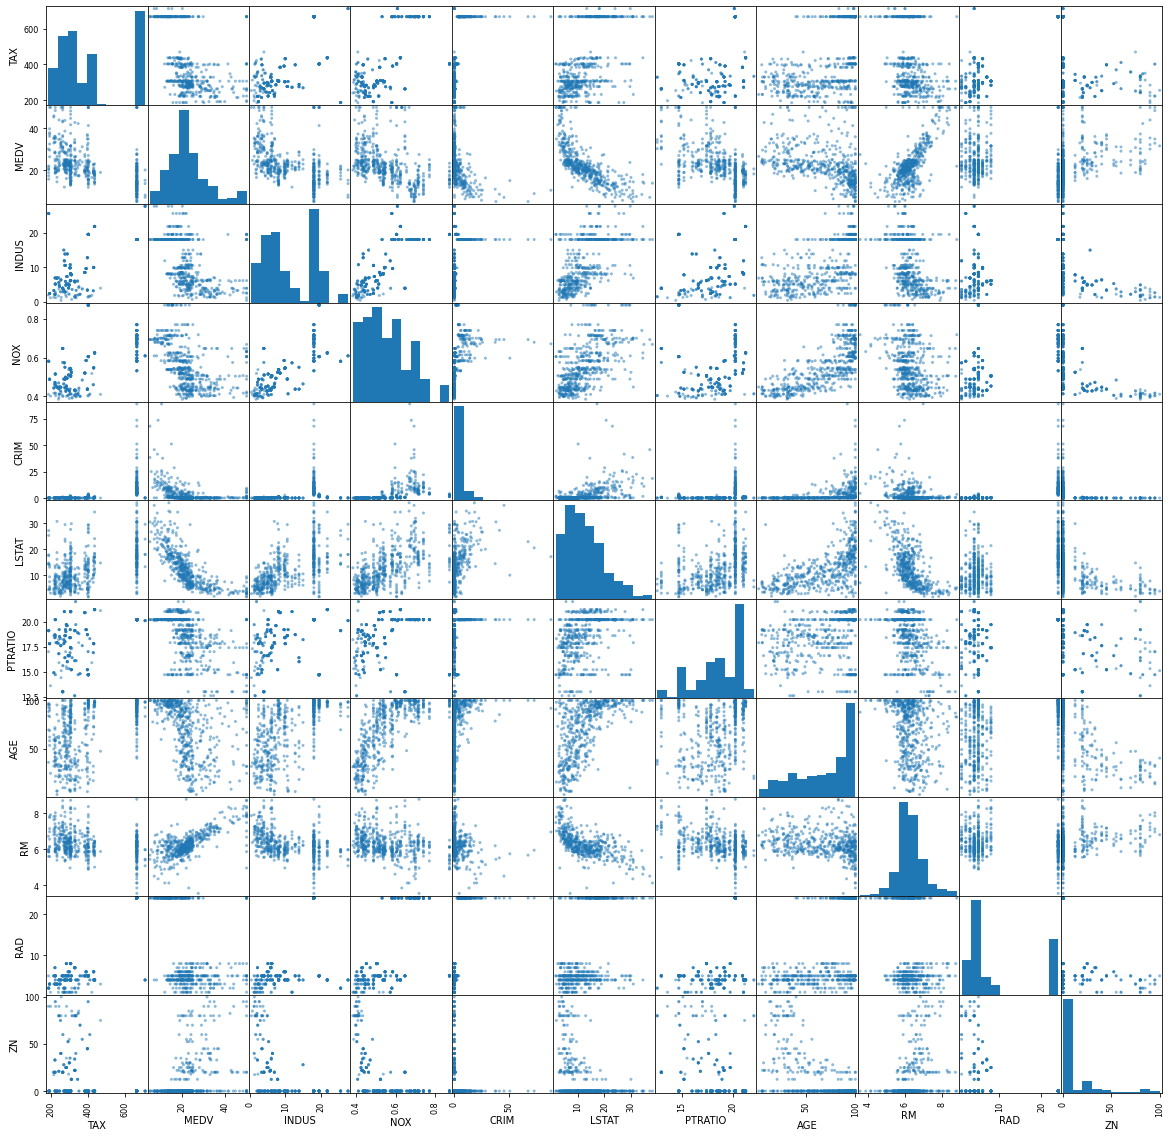

In [7]:
%matplotlib inline

atrs = set(dfy.columns) - {"DIS", "CHAS", "B"}
_ = pd.plotting.scatter_matrix(dfy[list(atrs)], figsize=(20,20))

Podobny `scatter_matrix` ale na mniejszą skalę, jedynie z niektórymi cechami. 

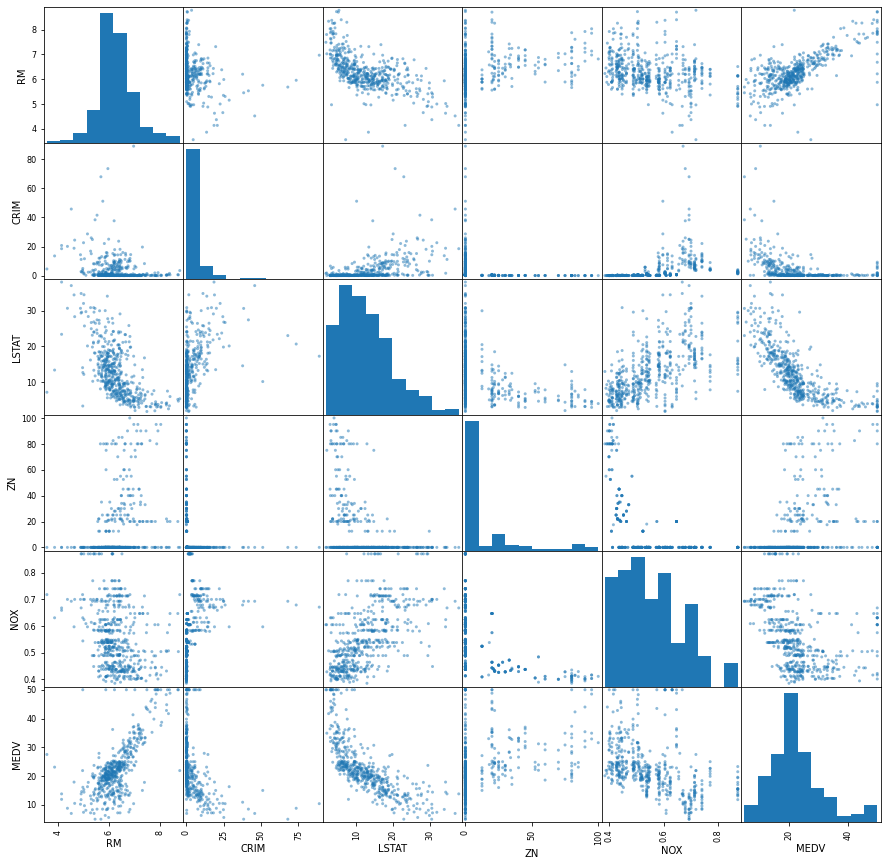

In [8]:
good_params = ["RM","CRIM","LSTAT", "ZN", "NOX"]
_ = pd.plotting.scatter_matrix(dfy[good_params+["MEDV"]], figsize=(15,15))

Wyświetlanie histogramów dla każdej cechy.

Można tutaj zauważyć że:
* **RM** ma rozkład normalny
* **CHAS** posiada prawie same wartości `0` i kilka `1`
* Większość domów ma wskaźnik **CRIM** poniżej `20`

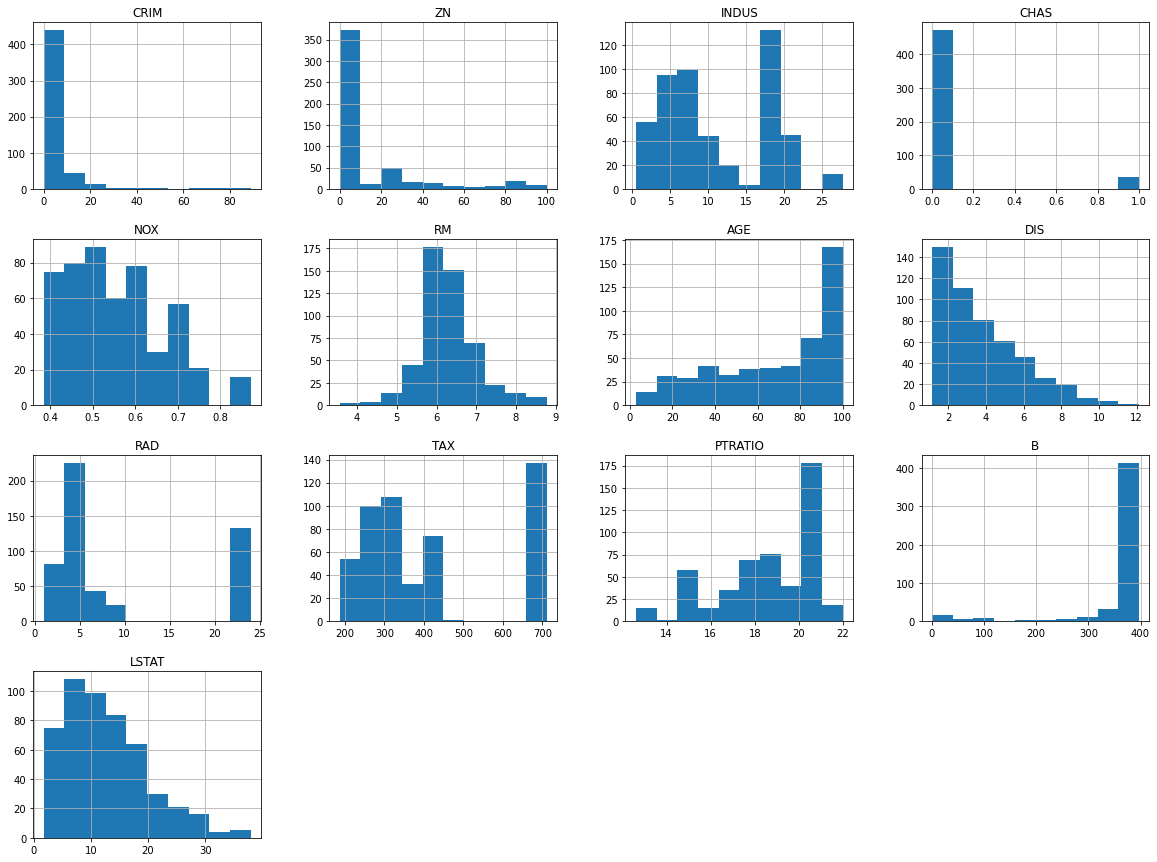

In [9]:
_ = df.hist(figsize=(20,15))

### Podział na zbiór uczący i treningowy
Wykonanie tego kroku jest bardzo proste i potrzebne aby można było ocenić nasz model. Innaczej model który mógłby się dostatecznie dobrze dopasować do danych mógłby uzyskać 100% dokładności co nie było by zbyt pomocne. **20%** danych zostanie użytych do testowania modelu.

In [10]:
train_x, test_x, train_y, test_y = skms.train_test_split(df, target, test_size=0.2)

print(f"Train set shape: {train_x.shape}, {train_y.shape}")
print(f"Test set shape: {test_x.shape}, {test_y.shape}")

Train set shape: (404, 13), (404,)
Test set shape: (102, 13), (102,)


### Regresja liniowa ze skalowaniem
Pierwszym eksperymentem będzie regresja liniowa ze skalowaniem danych. Stworzyłem `pipeline` który najpierw skaluje dane (normalizując je do średniej `0` i odchyleniem równym `1`) a następnie wykonuje regresję liniową.

In [11]:
lr_pip = skpl.make_pipeline(skp.StandardScaler(), sklm.LinearRegression())
lr_pip.fit(train_x, train_y)

test_sample = test_x[4:5]

displmd(f"For input data")
display(test_sample)
displmd(f"Model returned `{lr_pip.predict(test_sample)}` and actual value is `{test_y[0]}`")

For input data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
66,0.04379,80.0,3.37,0.0,0.398,5.787,31.1,6.6115,4.0,337.0,16.1,396.9,10.24


Model returned `[26.68143195]` and actual value is `35.4`

Model nie pomylił się dużo. Różnica wynosi `4` co na tle `2` jest całkiem sensownym błędem.

Model można dokładnie zwalidowć przy użyciu **zbioru testowego** i specjalnych funkcji służących do oceny.  

In [12]:
def validate(x, y, model, cv=[3, 5, 10]):
    displmd(
f"""#### Whole set validatioe
* `mse` - {skm.mean_squared_error(model.predict(x), y):0.2f}
* `tmae` - {skm.mean_absolute_error(model.predict(x), y):0.2f}
* `r2` - {skm.r2_score(model.predict(x), y):0.2f}""")

    def display_score(scores):
        str_scores = f"`[{' '.join(f'{s:0.2f}' for s in scores)}]`" if len(scores) <= 4 else f"`[{scores[0]:0.2f} {scores[1]:0.2f} ... {scores[-1]:0.2f}]`"
        displmd(f" * scores ({len(scores)}): {str_scores}, mean: `{scores.mean():0.2f}`, std: `{scores.std():0.2f}`\n")
    
    displmd("### Cross validation")
    for cv in cv:
        display_score(skms.cross_val_score(model, x, y, cv=cv))

    return skm.r2_score(model.predict(x), y)

cross_outputs = dict()

displmd("## Testing")
_ = validate(test_x, test_y, lr_pip)

displmd("## Testing on Train Set")
_ = validate(train_x, train_y, lr_pip)

## Testing

#### Whole set validatioe
* `mse` - 23.61
* `tmae` - 3.58
* `r2` - 0.54

### Cross validation

 * scores (3): `[0.65 0.74 0.78]`, mean: `0.72`, std: `0.06`


 * scores (5): `[0.66 0.57 ... 0.81]`, mean: `0.73`, std: `0.10`


 * scores (10): `[0.30 0.75 ... 0.83]`, mean: `0.68`, std: `0.24`


## Testing on Train Set

#### Whole set validatioe
* `mse` - 21.80
* `tmae` - 3.26
* `r2` - 0.65

### Cross validation

 * scores (3): `[0.71 0.75 0.58]`, mean: `0.68`, std: `0.07`


 * scores (5): `[0.80 0.71 ... 0.46]`, mean: `0.70`, std: `0.12`


 * scores (10): `[0.79 0.81 ... 0.64]`, mean: `0.69`, std: `0.17`


W outpucie widzimy: 
* Błąd średniowkadratowy
* Błąd bezwzględny
* r2 score
* cross validation score dla 3 różnych podziałów (na 3 na 5 i na 10 części)

Wykorzytsam tą funkcję do porównania innych modeli

### Regresja bez skalowania
Żeby sprawdzić czy regresja liniowa jest czuła na skalowanie danych, spróbuję wykonać regresję bez skalowania. 

In [13]:
lr_nscale = skpl.make_pipeline(sklm.LinearRegression())
lr_nscale.fit(train_x, train_y)

_ = validate(test_x, test_y, lr_nscale)

#### Whole set validatioe
* `mse` - 23.61
* `tmae` - 3.58
* `r2` - 0.54

### Cross validation

 * scores (3): `[0.65 0.74 0.78]`, mean: `0.72`, std: `0.06`


 * scores (5): `[0.66 0.57 ... 0.81]`, mean: `0.73`, std: `0.10`


 * scores (10): `[0.30 0.75 ... 0.83]`, mean: `0.68`, std: `0.24`


Jak widac błąd jest **dokładnie** taki sam jak w przypadku regresji liniowej ze skalowaniem, więc regresja liniowa nie jest czuła na skalowanie danych i można ten krok pominąć przynajmniej w tym przypadku. Chociaż skalowanie na pewno zmienia to parametry modelu.

### Analiza wspołczynników
Sprawdźmy jakie są **optymalnie** wpółczynniki obliczone przez algorytm, jakie cechy są najważniejsze i jak parametry zmieniły się dla modelu bez skalowania i ze skalowaniem.

In [14]:
coef = lr_nscale[0].coef_           # type: ignore
intercept = lr_nscale[0].intercept_ # type: ignore

displmd(f"## Without scaling")
print(coef, intercept)

displmd(f"## With scaling")
print(lr_pip[1].coef_, lr_pip[1].intercept_)    # type: ignore

## Without scaling

[-9.38726384e-02  4.79948110e-02 -3.83986692e-02  2.05611897e+00
 -2.04585946e+01  3.38811186e+00  4.25486851e-03 -1.55315187e+00
  2.88929819e-01 -1.01316552e-02 -1.07543107e+00  9.15710207e-03
 -4.99987935e-01] 42.70572710032708


## With scaling

[-0.80152758  1.1213172  -0.2624092   0.53073962 -2.33233546  2.46420679
  0.11889485 -3.28020731  2.54740292 -1.73182484 -2.27738062  0.84748693
 -3.60119908] 22.443564356435648


Wartości w modelu bez skalowania są bardzo skrajne (niektóre są `e-03` a inne `e+01`), a w modelu ze skalowaniem współczynniki są na tyle małe że nie potrzeba notacji naukowej do przedstawienia ich wartości (wszystkie są w zakresie `+/-10` poza `intercept_`) i można łatwo je ze sobą porównać.

### Sprawdzanie czy model działa
Taki model można łatwo obliczyć przy użyciu prostych działań na macierzach.
$$
Y = X \theta^T + \beta
$$

In [15]:
y = lr_nscale.predict(test_sample)

y_by_hand = np.dot(test_sample, coef.T) + intercept

print(f"Model predicted {y} and by hand {y_by_hand}")

Model predicted [26.68143195] and by hand [26.68143195]


# Wnioski
Regresja liniowa to prosty algorytm pozwalający na szybkie przewidywanie wartości w przypadku cech które są liniowo zależne od wartości docelowej. W tym przypadku model. 

Algorytm ten nie jest czuły na skalowanie danych, więc można go wykonać bez tego kroku, chociaż skalowanie znacząco zmienia parametry modelu. 

Walidowanie modeló przy użyciu `r2_score` jest bardzo proste z użyciem `sklearn` i pozwala szybko i prosto ocenić model

